# Productivización de un modelo de Machine Learning

In [1]:
import lightgbm 
import os
from google.colab import drive
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split##
######################################################

#Definimos las métricas
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve


import matplotlib.pyplot as plt
import pickle

In [2]:
#Levanto drive para poder almacenar los archivos
drive.mount("/content/drive")
contentFolder = "/content/drive/MyDrive/Austral - Data Mining"
if not os.path.exists(contentFolder):
    os.mkdir(contentFolder)

Mounted at /content/drive


In [ ]:
data = pd.read_csv("{}/Covid19CasosReducido.zip".format(contentFolder), compression="zip")

In [ ]:
data1 = data.sample(frac=0.8)
data2 = data.loc[~data.index.isin(data1.index)]

data1.to_csv("{}/Covid19Entrenamiento.zip".format(contentFolder), compression="zip", index=False)
data2.to_csv("{}/Covid19Validacion.zip".format(contentFolder), compression="zip", index=False)


In [3]:
def preprocesamiento(data):
  for x in [y for y in data.columns if "fecha" in y]:
      data[x] = pd.to_datetime(data[x], format = "%Y-%m-%d")


  medianasProvincia = data[data.edad.isnull()==False].groupby("residencia_provincia_nombre").edad.median()\
  .reset_index().rename(columns={"edad":"medianaEdad"})
  data = pd.merge(data, medianasProvincia, how="left", on="residencia_provincia_nombre")
  #Imputo la variable edad (aquellos nulos)
  data["edad"] = np.where(data.edad.isnull(), data.medianaEdad, data.edad)
  data["edad"] = np.where(data.edad <0 , data.edad * -1,data.edad)
  data["edad"] = np.where(data.edad > 110, 110, data.edad)
  #Drop de medianaEdad
  data = data.drop(columns=["medianaEdad"])
  data["decileEdad"] = pd.qcut(data.edad, 10, labels=False)
  data["edad"] = np.where(data.edad_años_meses == "Meses", round(data.edad/12,2), data.edad)

  #Creo variable dummies con sexo
  data = data.join(pd.get_dummies(data.sexo, prefix="sexo"))
  #Creo variable dummy con financiamiento
  data = data.join(pd.get_dummies(data.origen_financiamiento, prefix="financiamiento"))

  data["confirmado"] = np.where(data.clasificacion_resumen == "Confirmado", 1, 0)
  data["descartado"] = np.where(data.clasificacion_resumen == "Descartado", 1, 0)
  data["otros"] = np.where(~data.clasificacion_resumen.isin(["Confirmado", "Descartado"]), 1, 0)

  aux = data.groupby("carga_provincia_nombre").agg({
    "confirmado": "sum",
    "descartado": "sum"
  }).reset_index()
  aux["ratioDescartadoConfirmadoProvincia"] = aux["descartado"] / aux["confirmado"]
  data = pd.merge(data, aux[["carga_provincia_nombre", "ratioDescartadoConfirmadoProvincia"]], how="inner", on="carga_provincia_nombre")

  for x in ["cuidado_intensivo", "fallecido", "asistencia_respiratoria_mecanica"]:
    data[x] = np.where(data[x] == "SI",1,0)

  borrarColumnas = ["edad_años_meses", "residencia_provincia_id", "residencia_departamento_id",
                  "ultima_actualizacion","carga_provincia_id"]
  data.drop(columns = borrarColumnas, inplace=True)

  medianaGenero = data.groupby("sexo").agg({
    "edad":["median", "max"]
  }).reset_index()
  medianaGenero.columns = ["sexo", "medianaEdad", "maxEdad"]
  #Creamos sólo el ratio contra la mediana porque no nos sirve el maximo de edad
  data = pd.merge(data, medianaGenero[["sexo", "medianaEdad"]], how="inner", on = "sexo")
  data["ratioEdadGenero"] = data["edad"] / data["medianaEdad"]

  data["residencia_pais_nombre"] = np.where(data.residencia_pais_nombre == "SIN ESPECIFICAR", "Argentina", data.residencia_pais_nombre)
  data["extranjero"] = np.where(data.residencia_pais_nombre != "Argentina",1,0)

  medianaProvincia = data.groupby("residencia_provincia_nombre").agg({
    "edad":["median", "max"]
  }).reset_index()
  medianaProvincia.columns = ["residencia_provincia_nombre", "medianaEdadProvincia", "maxEdad"]

  data = pd.merge(data, medianaProvincia[["residencia_provincia_nombre", "medianaEdadProvincia"]], how="left", on = "residencia_provincia_nombre")
  data["ratioEdadProvincia"] = data["edad"] / data["medianaEdadProvincia"]

  data["conSintomas"] = np.where(data.fecha_inicio_sintomas.isnull() == False,1,0)

  columns = ["id_evento_caso", "ratioEdadGenero", "ratioEdadProvincia", "extranjero", "confirmado", "descartado",
  "otros", "conSintomas" , "ratioDescartadoConfirmadoProvincia", "sexo_F",
  "sexo_M", "sexo_NR",  "decileEdad", "financiamiento_Privado", "financiamiento_Público", "fallecido"]

  return data[columns]



In [4]:
data = pd.read_csv("{}/Covid19Entrenamiento.zip".format(contentFolder), compression="zip")
data = preprocesamiento(data)

In [5]:
X = data.drop(columns = ["id_evento_caso", "fallecido"])
y = data.fallecido
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lgbModel = lightgbm.LGBMClassifier()
lgbModel.fit(X_train, y_train)

LGBMClassifier()

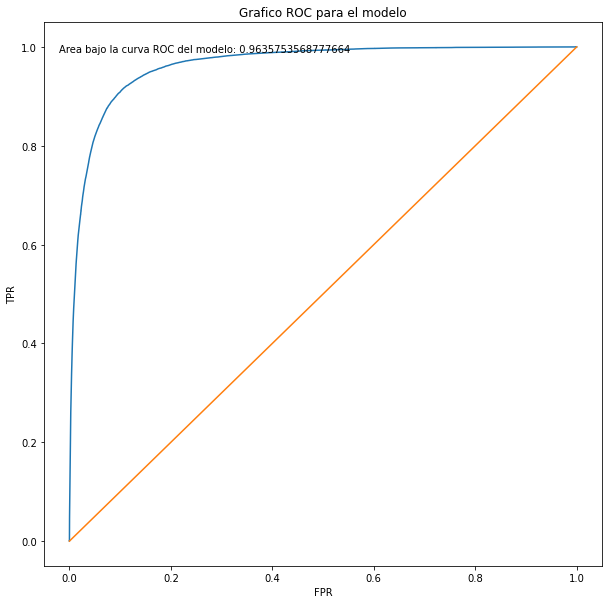

In [ ]:
lgbProbs = lgbModel.predict_proba(X_test)[:,-1]
#De esta forma graficamos la curva ROC y calculamos el área debajo de la curva
areaBajoCurvaRoc = roc_auc_score(y_test, lgbProbs)
fpr, tpr, _ = roc_curve(y_test, lgbProbs)
plt.figure(figsize=(10,10))
plt.title("Grafico ROC para el modelo")
plt.plot(fpr, tpr)
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.annotate('Area bajo la curva ROC del modelo: {}'.format(areaBajoCurvaRoc), (-0.02,0.99))
plt.show()

In [ ]:
X_test["probabilities"] =  lgbProbs
X_test["fallecido"] = y_test

#Normalizo el score
X_test["normalizedScore"] = X_test.probabilities * 1000
#Armo los buckets cada 100 puntos
X_test["bucket"] = pd.cut(X_test.normalizedScore, np.array([0,100,200,300,400,500,600,700,800,900,1000]))
#Armo los deciles por scores
X_test['decile'] = pd.qcut(X_test.probabilities, 10, labels=False)

measures = X_test.groupby("decile").agg({"fallecido": ["sum", "count"]})
measures.columns = ["fallecidos", "Casos"]
measures["noFallecidos"] = measures["Casos"]-measures["fallecidos"]
measures["% no Fallecidos"] = (measures["noFallecidos"] / len(X_test[X_test.fallecido == 0])).round(2)
measures["% Fallecidos"] = (measures["fallecidos"] / len(X_test[X_test.fallecido == 1])).round(2)
measures = measures.sort_index(ascending = False)
a = measures[["% no Fallecidos", "% Fallecidos"]]\
                .cumsum()\
                .rename(columns={"% no Fallecidos": "% no Fallecidos acum.", 
                                 "% Fallecidos": "% Fallecidos acum."})

measures = measures.join(a)
measures

,fallecidos,Casos,noFallecidos,% no Fallecidos,% Fallecidos,% no Fallecidos acum.,% Fallecidos acum.
decile,,,,,,,
9,17669,213284,195615,0.09,0.90,0.09,0.90
8,1189,213255,212066,0.10,0.06,0.19,0.96
7,349,213249,212900,0.10,0.02,0.29,0.98
6,170,213140,212970,0.10,0.01,0.39,0.99
5,98,213236,213138,0.10,0.00,0.49,0.99
4,68,213455,213387,0.10,0.00,0.59,0.99
3,29,213362,213333,0.10,0.00,0.69,0.99
2,17,213294,213277,0.10,0.00,0.79,0.99
1,10,206988,206978,0.10,0.00,0.89,0.99


In [ ]:
#Nuestro punto de corte
X_test[X_test.decile == 9].probabilities.min()

0.011478807020738037

In [ ]:
pickle.dump(lgbModel, open('{}/ligthGbmModel.sav'.format(contentFolder), 'wb'))